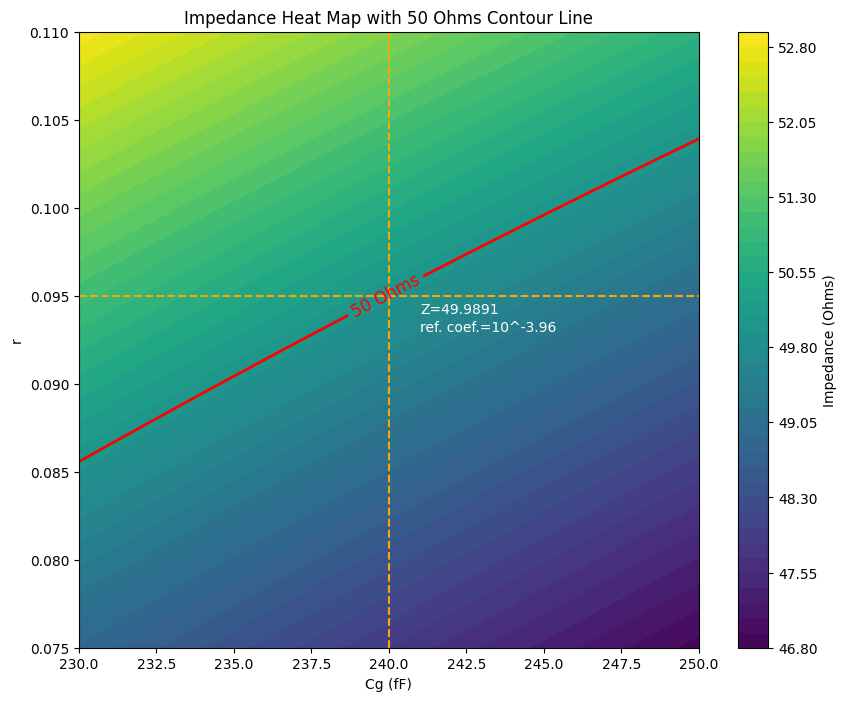

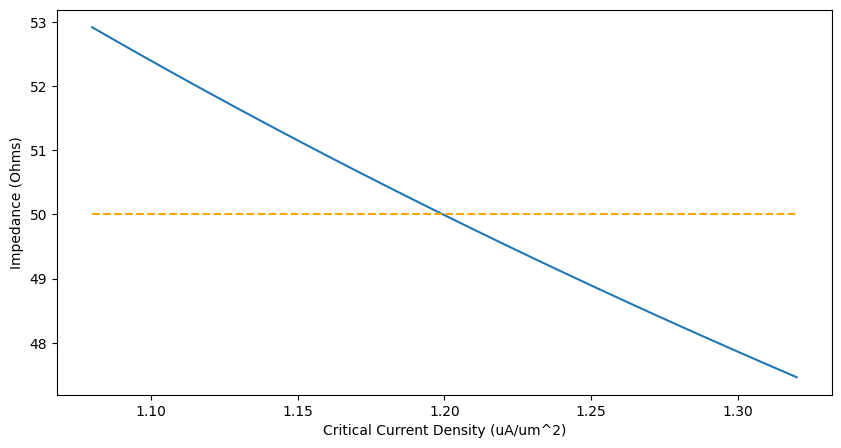

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize

h = 6.626e-34
e = 1.6e-19
Phi0 = h / (2 * e)

class MatchImpedance:
    """Class to solve for unit cell impedance. 
    Objective: find parameters to intrisically match 50 Ohm transmission line impedance.
    Model: Z0 = sqrt(L/Cg) where 
            L is solved below using Taylor expansion of SNAIL current equation and 
            Cg is capacitance to ground (ignores junction capacitance).
    Parameters:
        J0 = critical current density (uA / um^2)
        A = area of large junction (um^2)
        r_range = range of ratio values
        Cg_range = range of feasible ground capacitance values
        Lp = parastic pad inductance
    """
    def __init__(self, J0, A, Lp: float = None):
        self.A = A
        self.I0 = J0*A
        self.Lp = Lp
        self.Z_map = None
        self.R = None
        self.Cg = None
        self.phi_ext = np.pi

    def optimize_applied_flux(self):
        # Search around half a flux quantum
        result = minimize(lambda flux: self.g4(flux), Phi0 / 2, bounds=[(Phi0 / 4, 3 * Phi0 / 4)])
        optimal_flux = result.x[0] # = Phi0/2
        return optimal_flux
    
    def I(self, r, phi):
        return r * self.I0 * np.sin(phi) + self.I0 * np.sin(phi / 3 - self.phi_ext / 3)

    def alpha(self, r, phi_star):
        return r * np.cos(phi_star) + np.cos((phi_star - self.phi_ext) / 3) / 3

    def L(self, a):
        return abs(Phi0 / (2 * np.pi * self.I0 * a))

    def Leff (self, a):
        L0 = self.L(a)
        return L0 / (1 + self.Lp/L0)
    
    def Z0(self, L, Cg):
        return np.sqrt(L / Cg)

    def gamma(self, r, phi_star):
        return (r * np.cos(phi_star) + r * np.sin((phi_star - self.phi_ext) / 3) / 27) / 6

    def calculate_impedance(self, Cg, r):
        phi_s = fsolve(lambda phi: self.I(r, phi), 0)[0]
        a = self.alpha(r, phi_s)
        L = self.Leff(a) if self.Lp else self.L(a)
        return self.Z0(L, Cg)
    
    def reflection_coef(self, Z, Z0):
        return (Z-Z0)/(Z+Z0)

    def calculate_impedance_mesh(self, Cg_range, r_range):
        self.R, self.Cg = np.meshgrid(r_range, Cg_range)
        phi_s_values = [fsolve(lambda phi: self.I(r, phi), 0)[0] for r in r_range]
        a_values = [self.alpha(r, phi_s) for r, phi_s in zip(r_range, phi_s_values)]
        L_values = [self.Leff(a) for a in a_values] if self.Lp else [self.L(a) for a in a_values]
        self.Z_map = self.Z0(L_values, self.Cg)

    def plot_heatmap(self, Cg_range, r_range, Cg_mark: float=None, r_mark: float=None):
        if self.Z_map is None:
            self.calculate_impedance_mesh(Cg_range=Cg_range, r_range=r_range)
        
        plt.figure(figsize=(10, 8))
        plt.contourf(self.Cg * 1e15, self.R, self.Z_map, levels=50, cmap='viridis')
        cbar = plt.colorbar()
        cbar.set_label('Impedance (Ohms)')

        contour = plt.contour(self.Cg * 1e15, self.R, self.Z_map, levels=[40], colors='orange', linewidths=2)
        plt.clabel(contour, inline=True, fontsize=12, fmt='40 Ohms')
        
        contour = plt.contour(self.Cg * 1e15, self.R, self.Z_map, levels=[50], colors='red', linewidths=2)
        plt.clabel(contour, inline=True, fontsize=12, fmt='50 Ohms')

        contour = plt.contour(self.Cg * 1e15, self.R, self.Z_map, levels=[60], colors='orange', linewidths=2)
        plt.clabel(contour, inline=True, fontsize=12, fmt='60 Ohms')

        if r_mark : plt.hlines(r_mark, Cg_range[0] * 1e15, Cg_range[-1] * 1e15, colors="orange", linestyles="--")
        if Cg_mark : plt.vlines(Cg_mark, r_range[0], r_range[-1], colors="orange", linestyles="--")
        if r_mark and Cg_mark: 
            plt.text(x=Cg_mark+1, y=r_mark-0.001, s=f'Z={self.calculate_impedance(Cg_mark*1e-15, r_mark):.4f}', c='white')
            plt.text(x=Cg_mark+1, y=r_mark-0.002, s=f'ref. coef.=10^{np.log10(abs(self.reflection_coef(self.calculate_impedance(Cg_mark*1e-15, r_mark), 50))):.2f}', c='white')


        plt.xlabel('Cg (fF)')
        plt.ylabel('r')
        plt.title('Impedance Heat Map with 50 Ohms Contour Line')
        plt.show()

    def plot_current_vs_impedance(self, Cg, r, J0_range):
        I0_range = [self.A*J0 for J0 in J0_range]
        original_I0 = self.I0
        impedances = []
        for I0 in I0_range:
            self.I0 = I0
            impedances.append(self.calculate_impedance(Cg, r))

        plt.figure(figsize=(10,5))
        plt.plot(J0_range*1e6,impedances)
        plt.hlines(50, J0_range[0]*1e6, J0_range[-1]*1e6, colors="orange", linestyles="--")
        plt.xlabel('Critical Current Density (uA/um^2)')
        plt.ylabel('Impedance (Ohms)')
        plt.show()
        self.I0 = original_I0

# Example usage:
J0 = 1.2e-6  # A/um^2 #0.4-0.7uA
A = 0.88 * 2 # um^2
r_range = np.linspace(0.075, 0.11, 50)  # Range of r values
Cg_range = np.linspace(230e-15, 250e-15, 50)  # Range of Cg values

current_variation_percent = 10
J0_values = np.linspace(J0*(1-current_variation_percent/100), J0*(1+current_variation_percent/100), 50)

mi = MatchImpedance(J0=J0, 
                    A=A, 
                    Lp = 6e-11)
Cg_mark, r_mark = 240, 0.095
mi.plot_heatmap(Cg_range, r_range, Cg_mark, r_mark)
mi.plot_current_vs_impedance(Cg_mark*1e-15, r_mark, J0_values)